This notebook aims to demonstrate the influence of distractors in the input.

To do so, make the input at each time-step 4D (2D for the actual position of the dots, 2D for the distracting variables)
Then pass this through the same "visual encoder" / obfuscation network as before (just modified for twice as many inputs)

We want to show the following:
- If the encoder is linear, adding the distractors will increase the dimensionality of the encoding and decoder internal state
- If it is ReLU, training will ensure that only info about relevant variables get extracted

# Part 1: imports and definitions

In [1]:
# %matplotlib widget
import ipywidgets as widgets
from IPython.display import clear_output

import os
from tqdm import tqdm
from copy import deepcopy
import numpy as np
import torch as tch
import matplotlib
import matplotlib.pyplot as plt 
plt.rc('font', family='serif')
from torch.optim import Adam
from torch.nn import MSELoss
from mpl_toolkits.axes_grid1 import make_axes_locatable

from nets import *
from environment import *
from helpers import *

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

BASE_FOLDER = '/home/atf6569/my_scratch/SequenceWorkingMemory/distractors_study/'
n_epochs = 10000
bs = 256
lr = 5e-4
T = 5
observation_size = 128
decoder_state_size = 128
memory_size = 128

folder = BASE_FOLDER + 'T_{}/'.format(T)
os.makedirs(folder, exist_ok=True)

if tch.cuda.is_available():
    device = tch.device('cuda:0')
else:
    device = tch.device('cpu')

Introduce the training loop, which will be common

In [21]:
def train(enc, dec, env, extension='linear_'):
    best_error = 2**20
    test_every = 200
    # opt = Adam(dec.parameters(), lr=lr)
    # opt = Adam([enc.parameters(), dec.parameters()], lr=lr)
    enc_ = deepcopy(enc)
    dec_ = deepcopy(dec)

    del enc
    del dec 
    enc = enc_
    dec = dec_
    
    opt = Adam(list(enc.parameters()) + list(dec.parameters()), lr=lr)

    losses_train = np.zeros(n_epochs)
    losses_val = np.zeros(n_epochs)
    loss_fn = MSELoss()

    def update_lines(losses_train, losses_val):
        clear_output(wait=True)
        fig = plt.figure()
        plt.semilogy(range(len(losses_train)), losses_train)
        plt.semilogy(range(len(losses_val)), losses_val)
        plt.show()
        plt.close()

    for epoch in range(n_epochs):
        X, y, _ = env.get_sequences(bs=bs, T=T) 
        opt.zero_grad()
        encodings = enc(X)
        out = dec(encodings)
        loss = loss_fn(out, y[:,:, :2]) # This is where we remove the distractors !!
        loss.backward()
        opt.step()
        losses_train[epoch] = loss.item()

        if (epoch) % test_every == 0:
            print('Epoch {}'.format(epoch))
            with tch.set_grad_enabled(False):
                errors = []
                for _ in range(20):
                    X, y, _ = env.get_sequences(bs=bs, T=T) 
                    encodings = enc(X)
                    outputs = dec(encodings)
                    errors.append(loss_fn(outputs, y[:,:, :2]).item())
                
                losses_val[epoch-test_every:epoch] = np.mean(errors)

                if np.mean(errors) < best_error:
                    best_error = np.mean(errors)
                    best_dec = deepcopy(dec)
                    best_enc = deepcopy(enc)

            update_lines(losses_train[:epoch], losses_val[:epoch])
    
    tch.save(best_enc.state_dict(), folder+extension+'encoder.pt')
    tch.save(best_dec.state_dict(), folder+extension+'decoder.pt')
    env.save(folder+extension+'environment.pt')

    plt.close('all')
    return enc, dec

def test(enc, dec, env, extension='linear_'):
    enc.load_state_dict(tch.load(folder+extension+'encoder.pt'))
    dec.load_state_dict(tch.load(folder+extension+'decoder.pt'))
    env.load(folder+extension+'environment.pt')

    n_epochs_test = 100

    d_x = dec.out_layer.weight.detach().cpu().numpy()[0]
    d_y = dec.out_layer.weight.detach().cpu().numpy()[1]


    all_positions = np.zeros((n_epochs_test*bs, T, 2), np.float32)
    all_states = np.zeros((n_epochs_test*bs, T, decoder_state_size), np.float32)
    all_currents = np.zeros((n_epochs_test*bs, T, decoder_state_size), np.float32)
    all_inputs = np.zeros((n_epochs_test*bs, T, observation_size), np.float32)
    all_encodings = np.zeros((n_epochs_test*bs, T, memory_size), np.float32)
    all_distractors = np.zeros((n_epochs_test*bs, T, env.n_distractors), np.float32)
    loss_fn = MSELoss()
    tmp = []

    with tch.set_grad_enabled(False):
        for b_idx in range(n_epochs_test):
            X, y, _ = env.get_sequences(bs=bs, T=T) 
            encodings = enc(X)

            all_inputs[b_idx*bs:(b_idx+1)*bs] = X.detach().cpu().numpy()
            all_encodings[b_idx*bs:(b_idx+1)*bs] = encodings.detach().cpu().numpy()
            all_positions[b_idx*bs:(b_idx+1)*bs] = y[:,:, :2].detach().cpu().numpy()
            all_distractors[b_idx*bs:(b_idx+1)*bs] = y[:,:, 2:].detach().cpu().numpy()

            states, currents, outputs = dec.get_internal_states(encodings)

            all_currents[b_idx*bs:(b_idx+1)*bs] = currents.detach().cpu().numpy()
            all_states[b_idx*bs:(b_idx+1)*bs] = states.detach().cpu().numpy()

            loss = loss_fn(outputs, y[:,:,:2]).item()
            tmp.append(loss)

    print('Loss during test phase: {:.3e}'.format(np.mean(tmp)))

    
    # First, do a PCA on the encodings

    data = deepcopy(all_encodings[:, 0, :])
    pca_encodings = PCA() # Do not impose any limit on n_components just yet
    loadings = pca_encodings.fit_transform(data)

    print('With all pca components')
    fig, axes = evaluate_PCA(pca_encodings, data, verbose=True, do_figure=True)
    fig.suptitle('PCA on the encodings')
    axes[1].axvline(x=2*T, ls='--', c='g')
    axes[1].axvline(x=(2+env.n_distractors)*T, ls='--', c='r')
    plt.show()
    plt.close('all')

    # PCA with only 2T components to check it works as well

    print('With only 2T components')
    data = deepcopy(all_encodings[:, 0, :])
    restricted_PCA = PCA(n_components=2*T)
    relevant_loadings = restricted_PCA.fit_transform(data)
    # print('relevant loadings shape', relevant_loadings.shape)
    evaluate_PCA(restricted_PCA, data, verbose=True, do_figure=False)

    positions = np.reshape(all_positions, (all_positions.shape[0], -1))
    # print(positions.shape, data.shape)
    linreg = LinearRegression()
    linreg.fit(positions, relevant_loadings)

    print('Rotation + pca pipeline on the encodings')
    evaluate_rotation_pca_pipeline(restricted_PCA, linreg, data, positions)

    alignment_matrix_x = np.zeros((T, 2*T))
    alignment_matrix_y = np.zeros((T, 2*T))
    positions = np.zeros((all_positions.shape[0], 2*T))

    positions[:, :T] = all_positions[:,:,0]
    positions[:, T:] = all_positions[:,:,1]

    # Then, do one at each time-step of the decoding
    for t in range(T):
        data = all_states[:,t]
        pca_decoder_t = PCA() # Do not impose any limit on n_components just yet
        loadings = pca_decoder_t.fit_transform(data)

        # print('With all pca components')
        fig, axes = evaluate_PCA(pca_decoder_t, data, verbose=True, do_figure=True)
        fig.suptitle('PCA on decoder state at time t={}'.format(t+1))
        axes[1].axvline(x=2*T, ls='--', c='g')
        axes[1].axvline(x=(2+env.n_distractors)*T, ls='--', c='r')
        plt.show()
        plt.close('all')

        restricted_PCA = PCA(n_components=2*T)
        relevant_loadings = restricted_PCA.fit_transform(data)
        evaluate_PCA(restricted_PCA, data, verbose=True, do_figure=False)

        
        linreg = LinearRegression()
        linreg.fit(positions, relevant_loadings)

        print('Rotation + pca pipeline on the encodings')
        evaluate_rotation_pca_pipeline(restricted_PCA, linreg, data, positions)

        alignment_matrix_x[t] = restricted_PCA.inverse_transform(linreg.coef_.T).dot(d_x)
        alignment_matrix_y[t] = restricted_PCA.inverse_transform(linreg.coef_.T).dot(d_y)

    fig, axes= plt.subplots(2)
    axes[0].imshow(alignment_matrix_x)
    axes[0].set_title('Alignment with dx')

    axes[1].imshow(alignment_matrix_y)
    axes[1].set_title('Alignment with dy')

    plt.tight_layout()
    plt.show()

    

Part 2: with linear encoder and decoder

In [3]:
# Define networks independently of training to allow for hot-start
env = ContinuousDotsWithDistractors(T=T, observation_size=observation_size, device=device, distraction_level=0.)
env_distracting = ContinuousDotsWithDistractors(T=T, observation_size=observation_size, device=device, distraction_level=.5)
# env = ContinuousDots(T=T, observation_size=observation_size, device=device, distraction_level=0.)
lin_enc = SingleLayerEncoder(in_size=observation_size, out_size=memory_size, device=device, nonlinearity=None)
lin_dec = SingleLayerDecoder(in_size=memory_size, state_size=decoder_state_size, device=device, nonlinearity=None)

In linearEncoder, out_size= 128
Linear Decoder launched on device : cuda:0
Linear Decoder launched on device : cuda:0


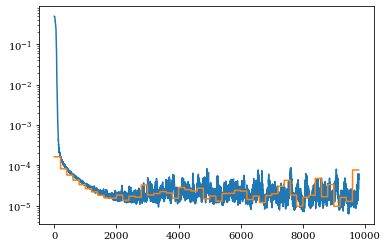

(SingleLayerEncoder(
   (in_layer): Linear(in_features=128, out_features=128, bias=False)
   (rec_layer): Linear(in_features=128, out_features=128, bias=False)
   (activation): Identity()
 ),
 SingleLayerDecoder(
   (in_layer): Linear(in_features=128, out_features=128, bias=False)
   (rec_layer): Linear(in_features=128, out_features=128, bias=False)
   (out_layer): Linear(in_features=128, out_features=2, bias=False)
   (activation): Identity()
 ))

In [4]:
train(lin_enc, lin_dec, env, extension='linear_')

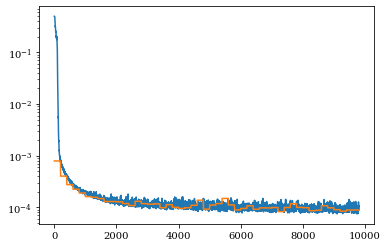

(SingleLayerEncoder(
   (in_layer): Linear(in_features=128, out_features=128, bias=False)
   (rec_layer): Linear(in_features=128, out_features=128, bias=False)
   (activation): Identity()
 ),
 SingleLayerDecoder(
   (in_layer): Linear(in_features=128, out_features=128, bias=False)
   (rec_layer): Linear(in_features=128, out_features=128, bias=False)
   (out_layer): Linear(in_features=128, out_features=2, bias=False)
   (activation): Identity()
 ))

In [5]:
train(lin_enc, lin_dec, env_distracting, extension='linear_distracting_')

Loss during test phase: 9.668e-06
With all pca components
PCA evaluation yielded ratio: 6.672e-07


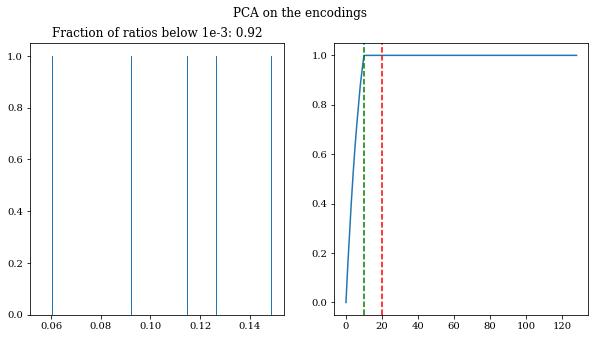

With only 2T components
PCA evaluation yielded ratio: 1.776e-02
Rotation + pca pipeline on the encodings
Norm ratio : 1.798289e-02
PCA evaluation yielded ratio: 6.806e-07


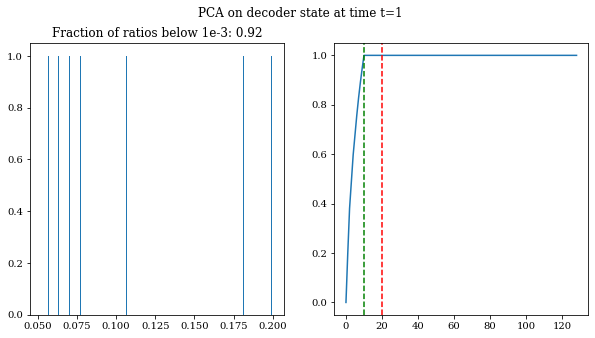

PCA evaluation yielded ratio: 3.643e-03
Rotation + pca pipeline on the encodings
Norm ratio : 4.482161e-03
PCA evaluation yielded ratio: 5.378e-07


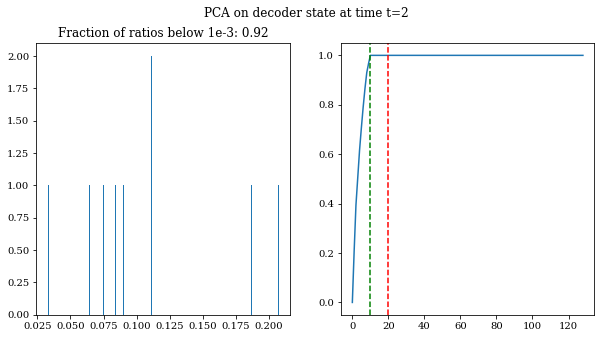

PCA evaluation yielded ratio: 2.139e-03
Rotation + pca pipeline on the encodings
Norm ratio : 3.349126e-03
PCA evaluation yielded ratio: 5.460e-07


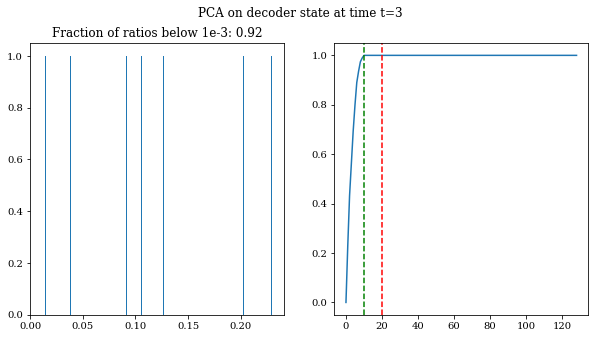

PCA evaluation yielded ratio: 1.377e-03
Rotation + pca pipeline on the encodings
Norm ratio : 2.923104e-03
PCA evaluation yielded ratio: 6.170e-07


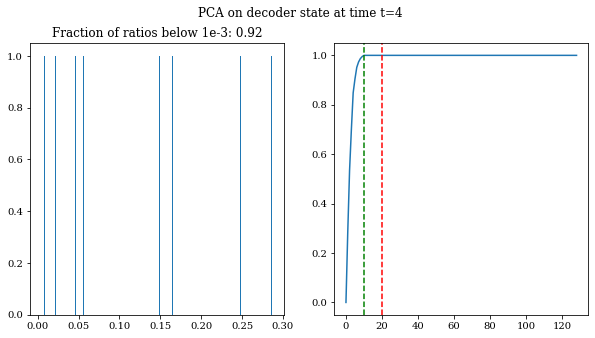

PCA evaluation yielded ratio: 1.091e-03
Rotation + pca pipeline on the encodings
Norm ratio : 2.832811e-03
PCA evaluation yielded ratio: 6.350e-07


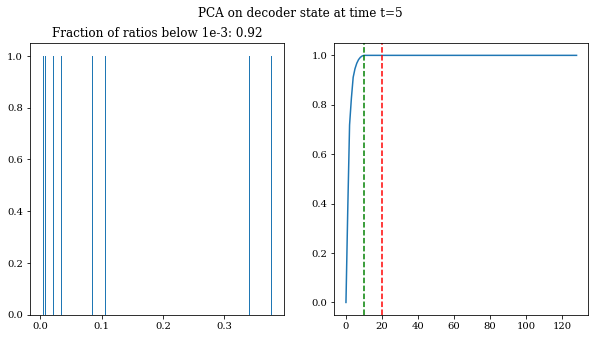

PCA evaluation yielded ratio: 9.972e-04
Rotation + pca pipeline on the encodings
Norm ratio : 2.938358e-03


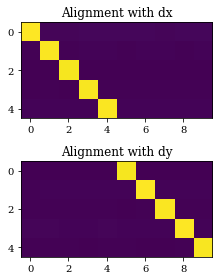

In [22]:
test(lin_enc, lin_dec, env, extension='linear_')

Loss during test phase: 8.471e-05
With all pca components
PCA evaluation yielded ratio: 7.289e-07


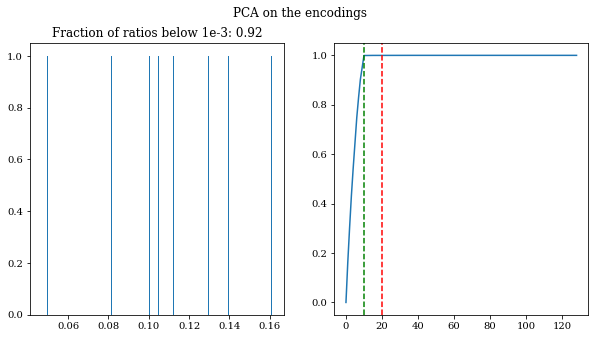

With only 2T components
PCA evaluation yielded ratio: 2.524e-02
Rotation + pca pipeline on the encodings
Norm ratio : 2.777536e-02
PCA evaluation yielded ratio: 6.397e-07


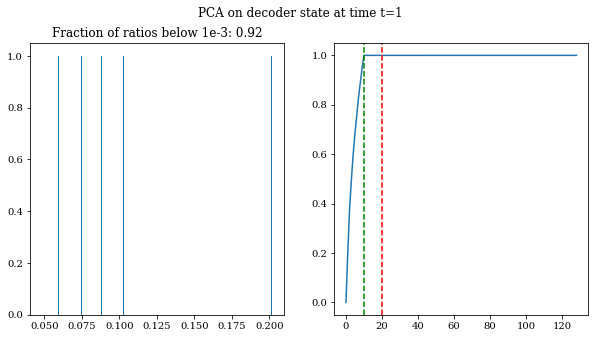

PCA evaluation yielded ratio: 5.286e-03
Rotation + pca pipeline on the encodings
Norm ratio : 1.234747e-02
PCA evaluation yielded ratio: 7.558e-07


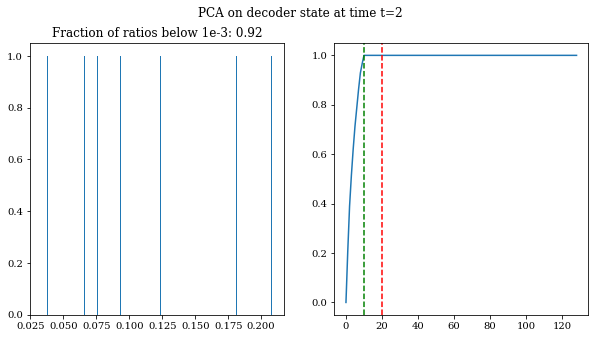

PCA evaluation yielded ratio: 2.908e-03
Rotation + pca pipeline on the encodings
Norm ratio : 1.142882e-02
PCA evaluation yielded ratio: 7.809e-07


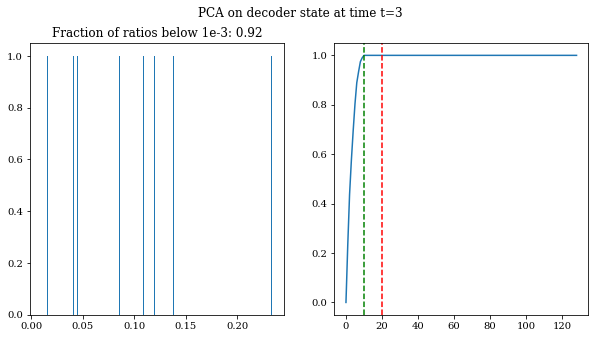

PCA evaluation yielded ratio: 1.888e-03
Rotation + pca pipeline on the encodings
Norm ratio : 1.115227e-02
PCA evaluation yielded ratio: 6.002e-07


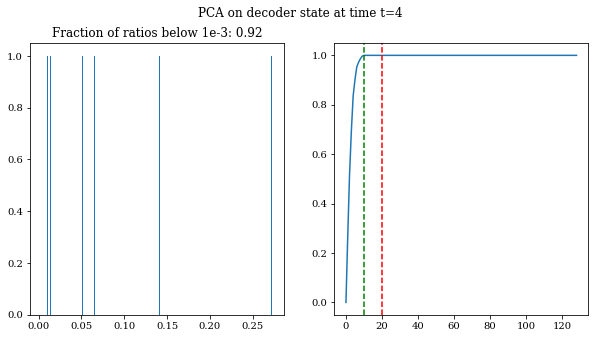

PCA evaluation yielded ratio: 1.372e-03
Rotation + pca pipeline on the encodings
Norm ratio : 1.099076e-02
PCA evaluation yielded ratio: 7.021e-07


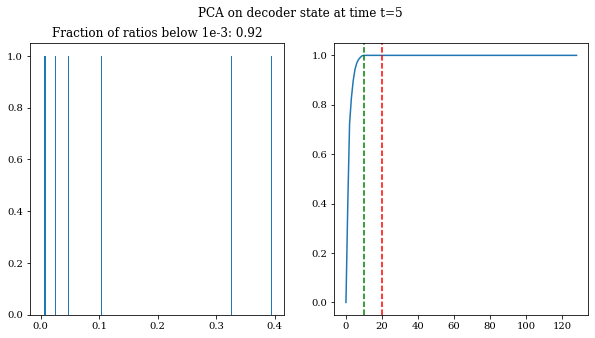

PCA evaluation yielded ratio: 1.138e-03
Rotation + pca pipeline on the encodings
Norm ratio : 1.083548e-02


In [7]:
test(lin_enc, lin_dec, env_distracting, extension='linear_distracting_')

# Part 2: relu networks

In [8]:
# Define networks independently of training to allow for hot-start
# env = ContinuousDotsWithDistractors(T=T, observation_size=observation_size, device=device)
# env = ContinuousDots(T=T, observation_size=observation_size, device=device)
env = ContinuousDotsWithDistractors(T=T, observation_size=observation_size, device=device, distraction_level=0.)
env_distracting = ContinuousDotsWithDistractors(T=T, observation_size=observation_size, device=device, distraction_level=.5)
# relu_enc = SingleLayerEncoder(in_size=observation_size, out_size=memory_size, device=device, nonlinearity='ReLU')
relu_enc = RNNSequenceEncoder(in_size=observation_size, out_size=memory_size, device=device, nonlinearity='ReLU')
relu_dec = SingleLayerDecoder(in_size=memory_size, state_size=decoder_state_size, device=device, nonlinearity='ReLU')

Linear Decoder launched on device : cuda:0


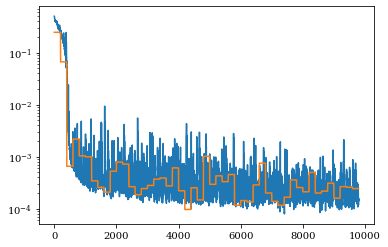

(RNNSequenceEncoder(
   (in_layer): Linear(in_features=128, out_features=1024, bias=True)
   (rec_layer): Linear(in_features=1024, out_features=1024, bias=True)
   (out_layer): Linear(in_features=1024, out_features=128, bias=True)
   (activation): ReLU()
 ),
 SingleLayerDecoder(
   (in_layer): Linear(in_features=128, out_features=128, bias=False)
   (rec_layer): Linear(in_features=128, out_features=128, bias=False)
   (out_layer): Linear(in_features=128, out_features=2, bias=False)
   (activation): ReLU()
 ))

In [9]:
train(relu_enc, relu_dec, env, extension='relu_')

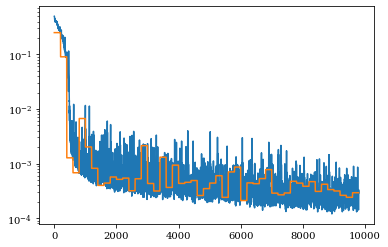

(RNNSequenceEncoder(
   (in_layer): Linear(in_features=128, out_features=1024, bias=True)
   (rec_layer): Linear(in_features=1024, out_features=1024, bias=True)
   (out_layer): Linear(in_features=1024, out_features=128, bias=True)
   (activation): ReLU()
 ),
 SingleLayerDecoder(
   (in_layer): Linear(in_features=128, out_features=128, bias=False)
   (rec_layer): Linear(in_features=128, out_features=128, bias=False)
   (out_layer): Linear(in_features=128, out_features=2, bias=False)
   (activation): ReLU()
 ))

In [10]:
train(relu_enc, relu_dec, env_distracting, extension='relu_distracting_')

Loss during test phase: 9.687e-05
With all pca components
PCA evaluation yielded ratio: 3.546e-07


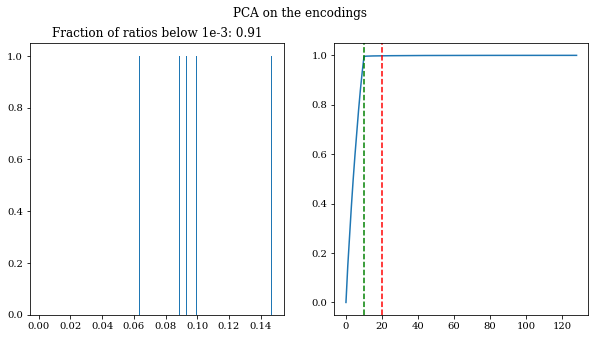

With only 2T components
PCA evaluation yielded ratio: 3.687e-02
Rotation + pca pipeline on the encodings
Norm ratio : 4.013756e-02
PCA evaluation yielded ratio: 1.863e-07


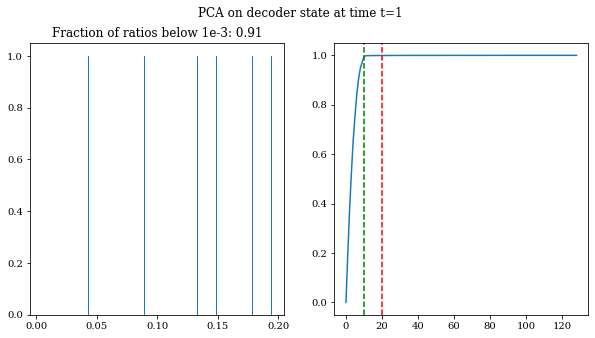

PCA evaluation yielded ratio: 2.302e-02
Rotation + pca pipeline on the encodings
Norm ratio : 2.540882e-02
PCA evaluation yielded ratio: 1.852e-07


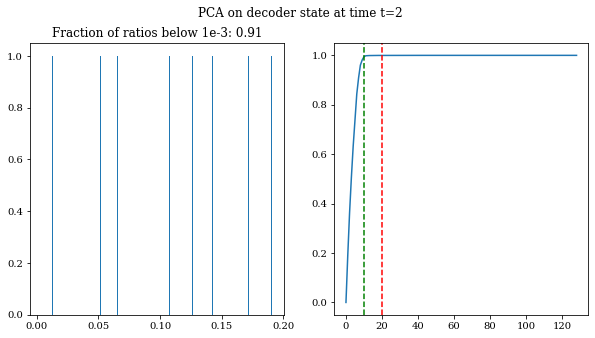

PCA evaluation yielded ratio: 1.951e-02
Rotation + pca pipeline on the encodings
Norm ratio : 2.592515e-02
PCA evaluation yielded ratio: 1.814e-07


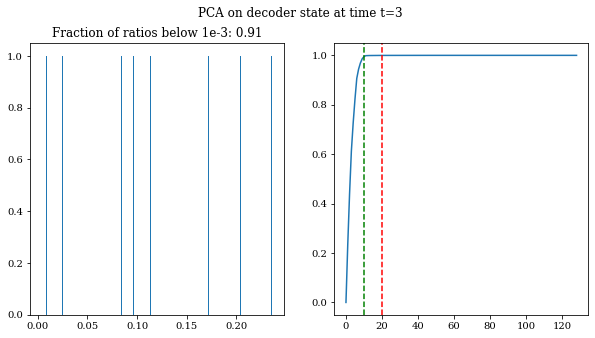

PCA evaluation yielded ratio: 1.770e-02
Rotation + pca pipeline on the encodings
Norm ratio : 2.523314e-02
PCA evaluation yielded ratio: 1.711e-07


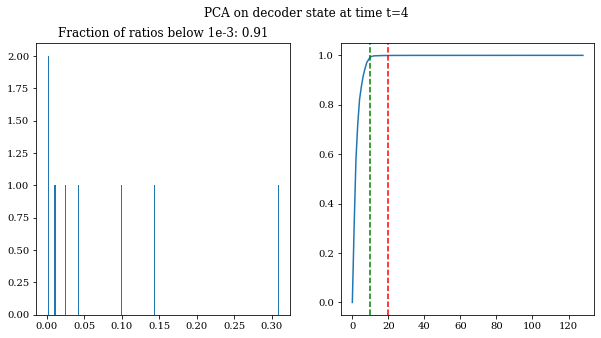

PCA evaluation yielded ratio: 2.001e-02
Rotation + pca pipeline on the encodings
Norm ratio : 2.986895e-02
PCA evaluation yielded ratio: 1.541e-07


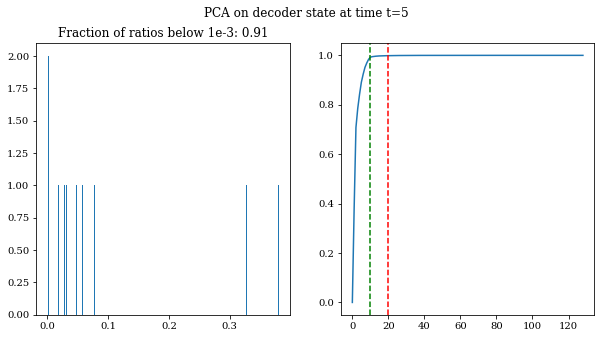

PCA evaluation yielded ratio: 2.101e-02
Rotation + pca pipeline on the encodings
Norm ratio : 3.082682e-02


In [11]:
test(relu_enc, relu_dec, env, extension='relu_')


Loss during test phase: 2.103e-04
With all pca components
PCA evaluation yielded ratio: 3.613e-07


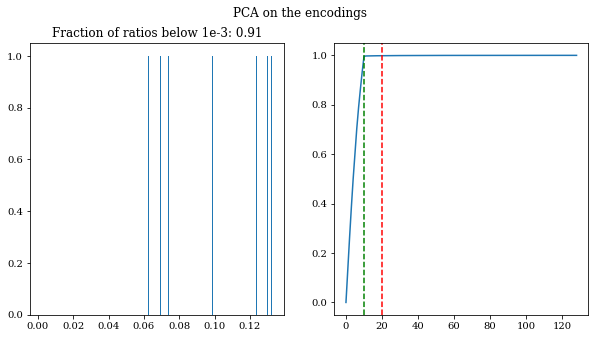

With only 2T components
PCA evaluation yielded ratio: 3.460e-02
Rotation + pca pipeline on the encodings
Norm ratio : 3.650407e-02
PCA evaluation yielded ratio: 2.232e-07


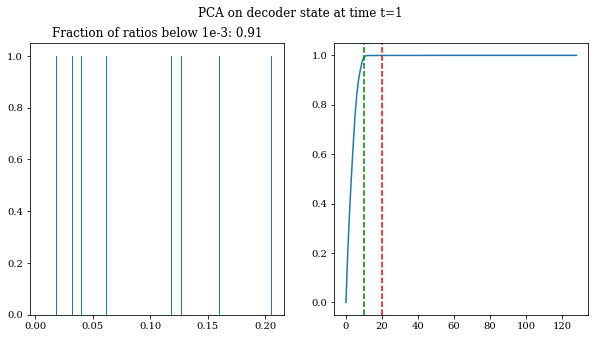

PCA evaluation yielded ratio: 2.445e-02
Rotation + pca pipeline on the encodings
Norm ratio : 2.633309e-02
PCA evaluation yielded ratio: 2.519e-07


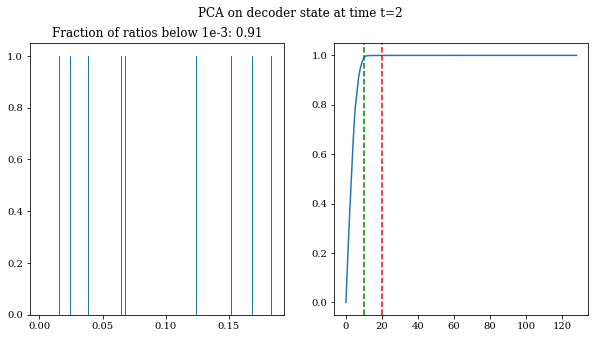

PCA evaluation yielded ratio: 2.523e-02
Rotation + pca pipeline on the encodings
Norm ratio : 2.717615e-02
PCA evaluation yielded ratio: 1.659e-07


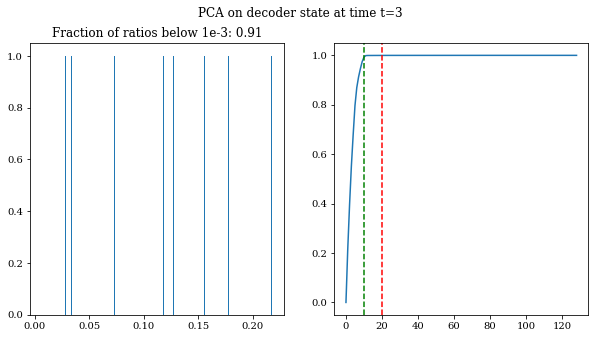

PCA evaluation yielded ratio: 1.904e-02
Rotation + pca pipeline on the encodings
Norm ratio : 2.457954e-02
PCA evaluation yielded ratio: 1.644e-07


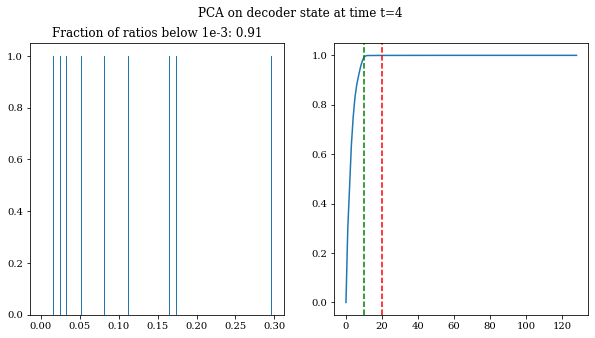

PCA evaluation yielded ratio: 1.889e-02
Rotation + pca pipeline on the encodings
Norm ratio : 2.511409e-02
PCA evaluation yielded ratio: 1.609e-07


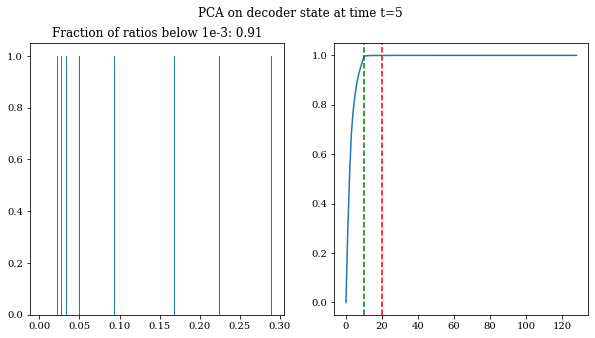

PCA evaluation yielded ratio: 1.593e-02
Rotation + pca pipeline on the encodings
Norm ratio : 2.552285e-02


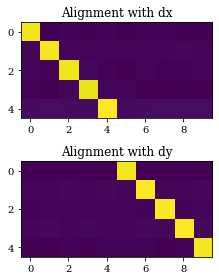

In [23]:
test(relu_enc, relu_dec, env_distracting, extension='relu_distracting_')